# DBSCAN CLUSTERING METHOD

In [32]:
#IMPORTS
import yfinance as yf
import pandas as pd
import pandas_ta_classic as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS  # You'll also need DBSCAN
from statsmodels.tsa.stattools import coint, grangercausalitytests
import warnings
import itertools
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# ADD THIS LINE for DBSCAN:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

In [33]:
# Data
stocks = [
    # S&P for Beta
    "^GSPC",
    # Megacap Leaders & Generalists
    "NVDA", "TSM", "AVGO", "AMD", "INTC", "MU", "TXN", "QCOM", "ADI", "MCHP",
    
    # Equipment & Manufacturing
    "ASML", "AMAT", "LRCX", "KLAC", "TER", "ENTG", "NVMI", "TOELY",
    
    # Specialized
    "ON", "NXPI", "STM", "LSCC", "MPWR", "QRVO", "SWKS", "ALAB", "CRDO",
    
    # Intellectual Property & Design Software
    "ARM", "SNPS", "CDNS", "CEVA",
    
    # Memory & Storage
    "WDC", "STX",
    
    # Emerging & Mid-Cap
    "GFS", "MRVL", "MTSI", "POWI", "SMTC", "VICR", "CAMT"
]

def fetch_data(stocks):
    data = yf.download(tickers=stocks, period="252d", interval="1h", 
                      group_by='ticker', auto_adjust=True, threads=True)
    
    price_series_list = []
    for s in stocks:
        try: 
            if s in data:
                series = data[s]['Close']
                series.name = s
                price_series_list.append(series)
        except Exception as e:
            pass

    if price_series_list:
        df = pd.concat(price_series_list, axis=1)
        df = df.ffill() 
        return df
    return pd.DataFrame()

df = fetch_data(stocks)

[*********************100%***********************]  41 of 41 completed


In [34]:
# 1. Clean and Prepare Price Data
if isinstance(df.columns, pd.MultiIndex):
    if 'Close' in df.columns.get_level_values(0):
        df = df['Close']
    elif 'Close' in df.columns.get_level_values(1):
        df = df.xs('Close', axis=1, level=1)

# 2. Base Calculations
returns_df = df.pct_change().dropna()
market_returns = returns_df['^GSPC']
window = 21 * 7  # Rolling window (~1 month of hourly data)

# 3. Time Series Feature Engineering (Dynamic Data)

# Feature A: Volatility (Risk)
rolling_vol = returns_df.rolling(window=window).std() * np.sqrt(252 * 7)

# Feature B: Beta to SPX (Market Sensitivity)
rolling_cov_mkt = returns_df.rolling(window=window).cov(market_returns)
rolling_mkt_var = market_returns.rolling(window=window).var()
rolling_beta_spx = rolling_cov_mkt.divide(rolling_mkt_var, axis=0)

# Feature C: Beta to Sector (Idiosyncratic moves vs The Pack)
sector_returns = returns_df.drop(columns=['^GSPC'], errors='ignore').mean(axis=1)
rolling_cov_sector = returns_df.rolling(window=window).cov(sector_returns)
rolling_sector_var = sector_returns.rolling(window=window).var()
rolling_beta_sector = rolling_cov_sector.divide(rolling_sector_var, axis=0)

# Feature D: RSI (Momentum/Overextended)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

rsi_df = df.apply(calculate_rsi)

# Feature E: Short Term Momentum (5-period return)
momentum_df = df.pct_change(periods=5)

# 4. Assemble the Master Time-Series DataFrame (ts_df)
ts_data_list = []

for ticker in stocks:
    if ticker == '^GSPC' or ticker not in df.columns: 
        continue
    
    # Extract features for this specific ticker
    temp_df = pd.DataFrame({
        'Price': df[ticker],
        'Returns': returns_df[ticker],
        'Rolling_Vol': rolling_vol[ticker],
        'Beta_SPX': rolling_beta_spx[ticker],
        'Beta_Sector': rolling_beta_sector[ticker],
        'RSI': rsi_df[ticker],
        'Momentum_5H': momentum_df[ticker]
    }, index=df.index)
    
    temp_df['Ticker'] = ticker
    ts_data_list.append(temp_df)

if ts_data_list:
    ts_df = pd.concat(ts_data_list).reset_index().set_index(['Datetime', 'Ticker'])
    # Drop NaNs created by rolling windows
    ts_df = ts_df.dropna()
    print("Time-Series DataFrame (ts_df) Created Successfully!")
    print(ts_df.head())

Time-Series DataFrame (ts_df) Created Successfully!
                                       Price   Returns  Rolling_Vol  Beta_SPX  \
Datetime                  Ticker                                                
2025-03-10 13:30:00+00:00 NVDA    108.064400 -0.041387     0.524506  2.300102   
2025-03-10 14:30:00+00:00 NVDA    107.658203 -0.003759     0.524169  2.298808   
2025-03-10 15:30:00+00:00 NVDA    108.084999  0.003964     0.523730  2.292151   
2025-03-10 16:30:00+00:00 NVDA    107.060097 -0.009482     0.524352  2.293648   
2025-03-10 17:30:00+00:00 NVDA    106.760002 -0.002803     0.524333  2.287557   

                                  Beta_Sector        RSI  Momentum_5H  
Datetime                  Ticker                                       
2025-03-10 13:30:00+00:00 NVDA       1.156916  29.182545    -0.008629  
2025-03-10 14:30:00+00:00 NVDA       1.158854  29.876423    -0.025796  
2025-03-10 15:30:00+00:00 NVDA       1.158460  37.235961    -0.037105  
2025-03-10 16:30:00+

DBScans - Auto Detect Epsilon Value

DBSCAN CLUSTERING (ROBUST EPS SELECTION)

[1/7] Aggregating features across time...
   Features shape: (40, 12)
   Tickers used: 40

[2/7] Scaling and applying PCA...
   PCA components: 4
   Explained variance: 94.17%

[3/7] Computing k-distance curve...
   k-distance stats -> min=0.9079, median=1.5844, max=4.4833


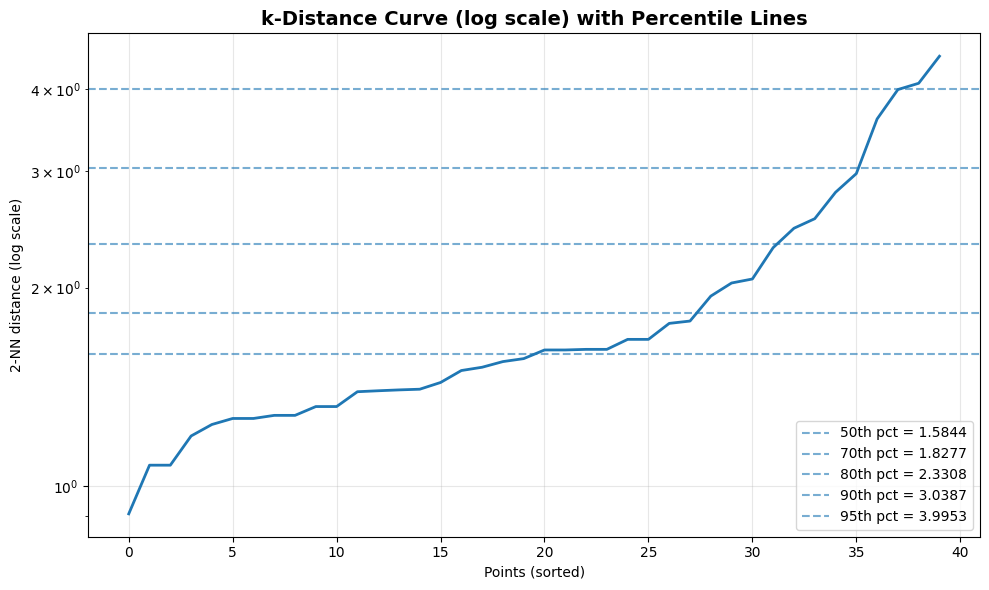


[4/7] Sweeping eps candidates and scoring...

Top eps candidates by score:
        eps  clusters  noise_frac  median_cluster_size  max_cluster_size  \
2  1.540166         7       0.200                  4.0                 9   
3  1.560299         6       0.200                  5.5                 9   
1  1.509604         5       0.300                  6.0                 9   
0  1.472508         5       0.350                  6.0                 9   
4  1.608350         5       0.200                  7.0                12   
5  1.609185         5       0.200                  7.0                12   
6  1.611764         5       0.200                  7.0                12   
7  1.640507         5       0.175                  7.0                12   

    score  
2  12.000  
3  11.000  
1  10.000  
0  10.000  
4  10.000  
5  10.000  
6  10.000  
7   5.875  


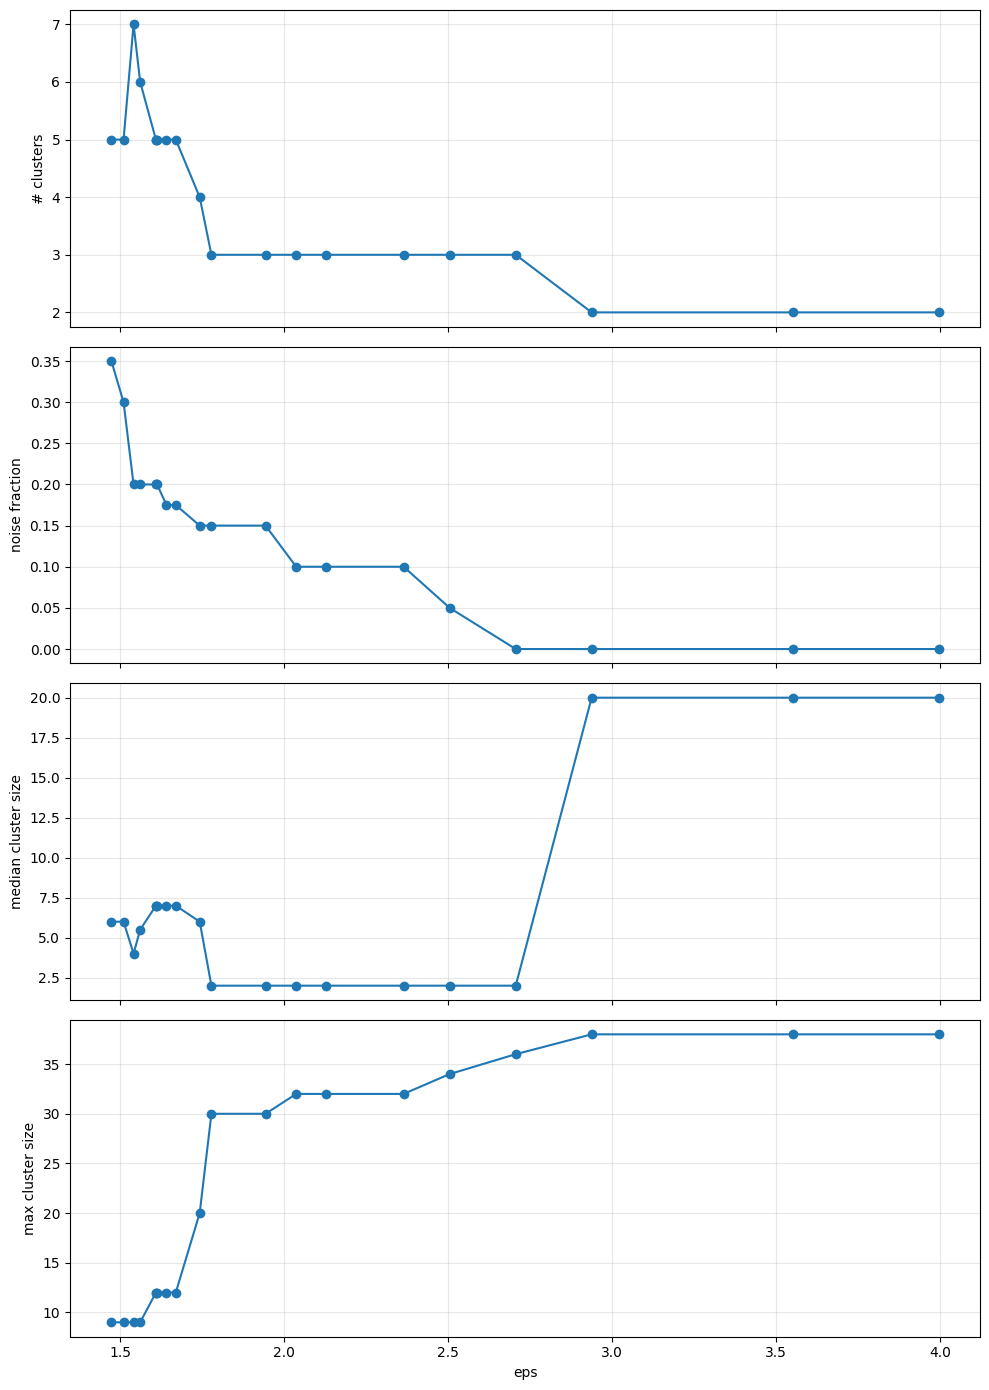


[5/7] Selecting best eps with guardrails...
   Selected eps = 1.5402
   Expected clusters = 7, noise = 20.00%

[6/7] Running final DBSCAN...
   Final -> eps=1.5402, min_samples=2
   Clusters found: 7
   Noise points: 8 (20.00%)
   Clustered points: 32

[7/7] t-SNE visualization + cluster membership...


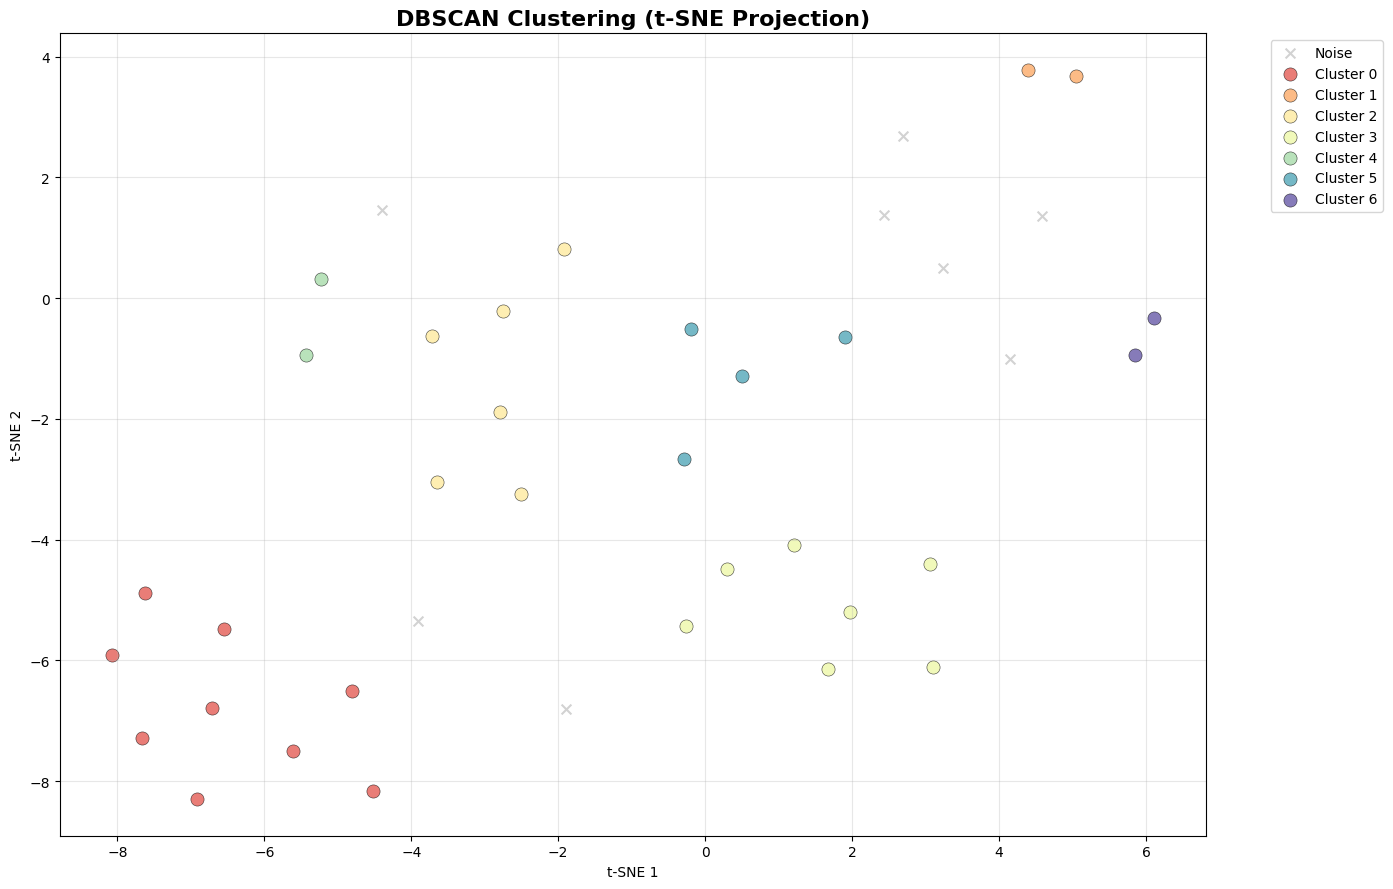


Cluster Assignments:

Noise (8 stocks):
  AMD, INTC, MU, SMTC, SNPS, STM, TOELY, VICR

Cluster 0 (9 stocks):
  ADI, CDNS, GFS, NXPI, POWI, QCOM, QRVO, SWKS, TXN

Cluster 1 (2 stocks):
  ALAB, CRDO

Cluster 2 (6 stocks):
  AMAT, AVGO, KLAC, LRCX, MTSI, NVDA

Cluster 3 (7 stocks):
  ARM, CEVA, ENTG, LSCC, MCHP, MRVL, ON

Cluster 4 (2 stocks):
  ASML, TSM

Cluster 5 (4 stocks):
  CAMT, MPWR, NVMI, TER

Cluster 6 (2 stocks):
  STX, WDC

✓ Done. Variables created:
  - labels: cluster assignments
  - cluster_df: ticker -> cluster mapping
  - X_pca: PCA feature matrix
  - eps, min_samples: DBSCAN params used


In [ ]:
# ============================================================================
# DBSCAN EPS SELECTION + CLUSTERING (FULL DROP-IN BLOCK)
# - Replaces your knee-based eps selection with a percentile sweep + guardrails
# - Explicitly avoids eps too low (all noise) and eps too high (one mega-cluster)
# - Produces plots + chooses a best eps automatically
# ============================================================================

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 70)
print("DBSCAN CLUSTERING (ROBUST EPS SELECTION)")
print("=" * 70)

# ----------------------------------------------------------------------------
# STEP 1: PREPARE FEATURE MATRIX FROM TIME-SERIES DATA
# ----------------------------------------------------------------------------

features_to_cluster = ['Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']

print("\n[1/7] Aggregating features across time...")
agg_dict = {col: ['mean', 'std'] for col in features_to_cluster if col in ts_df.columns}
ticker_features = ts_df.groupby(level='Ticker').agg(agg_dict)
ticker_features.columns = ['_'.join(col).strip() for col in ticker_features.columns.values]

# DBSCAN can't handle NaNs
ticker_features = ticker_features.dropna()
tickers = ticker_features.index.tolist()

print(f"   Features shape: {ticker_features.shape}")
print(f"   Tickers used: {len(tickers)}")

# ----------------------------------------------------------------------------
# STEP 2: STANDARDIZE AND APPLY PCA
# ----------------------------------------------------------------------------

print("\n[2/7] Scaling and applying PCA...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ticker_features)

variance_threshold = 0.90
pca = PCA(n_components=variance_threshold, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"   PCA components: {X_pca.shape[1]}")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# ----------------------------------------------------------------------------
# STEP 3: BUILD k-DISTANCES (FOR eps CANDIDATES + VISUALIZATION)
# ----------------------------------------------------------------------------

print("\n[3/7] Computing k-distance curve...")
min_samples = 2
k = min_samples  # standard practice: use k=min_samples for the k-distance graph

nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_pca)
distances, _ = nbrs.kneighbors(X_pca)

# distance to the k-th neighbor (excluding self at index 0)
k_distances = np.sort(distances[:, k])

print(f"   k-distance stats -> min={k_distances.min():.4f}, median={np.median(k_distances):.4f}, max={k_distances.max():.4f}")

# Plot k-distance on log scale + percentiles
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_distances, linewidth=2)
ax.set_yscale('log')
ax.set_title('k-Distance Curve (log scale) with Percentile Lines', fontsize=14, fontweight='bold')
ax.set_xlabel('Points (sorted)')
ax.set_ylabel(f'{k}-NN distance (log scale)')
for q in [50, 70, 80, 90, 95]:
    eps_q = float(np.percentile(k_distances, q))
    ax.axhline(eps_q, linestyle='--', alpha=0.6, label=f'{q}th pct = {eps_q:.4f}')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# STEP 4: SWEEP eps VALUES + SCORE THEM (AVOIDS TOO LOW / TOO HIGH)
# ----------------------------------------------------------------------------

print("\n[4/7] Sweeping eps candidates and scoring...")

# Build eps candidates from k-distance percentiles (stable & robust)
# Avoid extreme low/high percentiles because they cause all-noise or mega-cluster.
percentiles = np.linspace(40, 95, 20)
eps_values = np.unique(np.percentile(k_distances, percentiles))
eps_values = eps_values[eps_values > 0]  # safety

results = []
N = X_pca.shape[0]

for eps_try in eps_values:
    db = DBSCAN(eps=float(eps_try), min_samples=min_samples, metric='euclidean')
    lbls = db.fit_predict(X_pca)

    n_clusters = len(set(lbls)) - (1 if -1 in lbls else 0)
    noise_frac = float(np.mean(lbls == -1))

    cluster_sizes = [int(np.sum(lbls == c)) for c in set(lbls) if c != -1]
    median_cluster_size = float(np.median(cluster_sizes)) if cluster_sizes else 0.0
    max_cluster_size = int(np.max(cluster_sizes)) if cluster_sizes else 0

    # Heuristic penalties:
    # - If eps too low -> noise_frac ~1, clusters ~0
    # - If eps too high -> one huge cluster (max_cluster_size ~ N, clusters ~1, noise ~0)
    # For pairs trading, we want:
    # - some noise (not 0)
    # - more than 1 cluster
    # - median cluster size >= 3 (avoid tons of size-2 "fake pair" clusters)
    # - avoid max cluster swallowing everything
    score = 0.0
    # reward more clusters, but not at any cost
    score += n_clusters * 1.0
    # prefer moderate noise (target band ~ 0.2 to 0.6)
    if 0.2 <= noise_frac <= 0.6:
        score += 3.0
    else:
        score -= abs(noise_frac - 0.4) * 5.0
    # prefer clusters that are not tiny
    if median_cluster_size >= 3:
        score += 2.0
    else:
        score -= (3 - median_cluster_size) * 2.0
    # penalize mega cluster domination
    if max_cluster_size > 0:
        domination = max_cluster_size / N
        if domination > 0.7:
            score -= (domination - 0.7) * 20.0

    results.append({
        'eps': float(eps_try),
        'clusters': int(n_clusters),
        'noise_frac': noise_frac,
        'median_cluster_size': median_cluster_size,
        'max_cluster_size': max_cluster_size,
        'score': score
    })

results_df = pd.DataFrame(results).sort_values('eps').reset_index(drop=True)

print("\nTop eps candidates by score:")
print(results_df.sort_values('score', ascending=False).head(8))

# Plot phase transition diagnostics
fig, ax = plt.subplots(4, 1, figsize=(10, 14), sharex=True)

ax[0].plot(results_df['eps'], results_df['clusters'], marker='o')
ax[0].set_ylabel('# clusters')
ax[0].grid(alpha=0.3)

ax[1].plot(results_df['eps'], results_df['noise_frac'], marker='o')
ax[1].set_ylabel('noise fraction')
ax[1].grid(alpha=0.3)

ax[2].plot(results_df['eps'], results_df['median_cluster_size'], marker='o')
ax[2].set_ylabel('median cluster size')
ax[2].grid(alpha=0.3)

ax[3].plot(results_df['eps'], results_df['max_cluster_size'], marker='o')
ax[3].set_ylabel('max cluster size')
ax[3].set_xlabel('eps')
ax[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# STEP 5: CHOOSE BEST eps (GUARDRAILS FIRST, SCORE SECOND)
# ----------------------------------------------------------------------------

print("\n[5/7] Selecting best eps with guardrails...")

# Guardrails: avoid all-noise and mega-cluster regimes
guarded = results_df[
    (results_df['clusters'] >= 2) &
    (results_df['noise_frac'].between(0.15, 0.70)) &
    (results_df['median_cluster_size'] >= 3) &
    (results_df['max_cluster_size'] <= int(0.75 * N))
].copy()

if len(guarded) == 0:
    print("[WARN] No eps met guardrails. Falling back to best score overall.")
    best_row = results_df.sort_values('score', ascending=False).iloc[0]
else:
    best_row = guarded.sort_values('score', ascending=False).iloc[0]

eps = float(best_row['eps'])
print(f"   Selected eps = {eps:.4f}")
print(f"   Expected clusters = {int(best_row['clusters'])}, noise = {best_row['noise_frac']:.2%}")

# ----------------------------------------------------------------------------
# STEP 6: RUN FINAL DBSCAN WITH SELECTED eps
# ----------------------------------------------------------------------------

print("\n[6/7] Running final DBSCAN...")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(X_pca)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int(np.sum(labels == -1))

print(f"   Final -> eps={eps:.4f}, min_samples={min_samples}")
print(f"   Clusters found: {n_clusters}")
print(f"   Noise points: {n_noise} ({n_noise/len(labels):.2%})")
print(f"   Clustered points: {len(labels) - n_noise}")

# ----------------------------------------------------------------------------
# STEP 7: VISUALIZE CLUSTERS (t-SNE) + PRINT MEMBERS
# ----------------------------------------------------------------------------

print("\n[7/7] t-SNE visualization + cluster membership...")

perplexity = max(2, min(30, len(X_pca)//3))
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
X_tsne = tsne.fit_transform(X_pca)

fig, ax = plt.subplots(figsize=(14, 9))
unique_labels = sorted(set(labels))
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for lab, col in zip(unique_labels, colors):
    mask = labels == lab
    if lab == -1:
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c='gray', marker='x',
                   s=50, alpha=0.35, label='Noise')
    else:
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[col], marker='o',
                   s=90, alpha=0.75, edgecolors='black', linewidths=0.4,
                   label=f'Cluster {lab}')

ax.set_title('DBSCAN Clustering (t-SNE Projection)', fontsize=16, fontweight='bold')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

cluster_df = pd.DataFrame({'Ticker': tickers, 'Cluster': labels})

print("\nCluster Assignments:")
for cluster_id in sorted(set(labels)):
    members = cluster_df[cluster_df['Cluster'] == cluster_id]['Ticker'].tolist()
    if cluster_id == -1:
        print(f"\nNoise ({len(members)} stocks):")
    else:
        print(f"\nCluster {cluster_id} ({len(members)} stocks):")
    print("  " + ", ".join(members))

print("\n✓ Done. Variables created:")
print("  - labels: cluster assignments")
print("  - cluster_df: ticker -> cluster mapping")
print("  - X_pca: PCA feature matrix")
print("  - eps, min_samples: DBSCAN params used")



DBScans - Enter Manual Epsilon Value 

DBSCAN CLUSTERING ANALYSIS

[1/6] Aggregating features across time...
   Features shape: (40, 12)
   Tickers: 40

[2/6] Scaling and applying PCA...
   PCA components: 4
   Explained variance: 94.17%

[3/6] Determining optimal epsilon...
   Mean k-distance: 2.1530
   Suggested epsilon: 4.7527


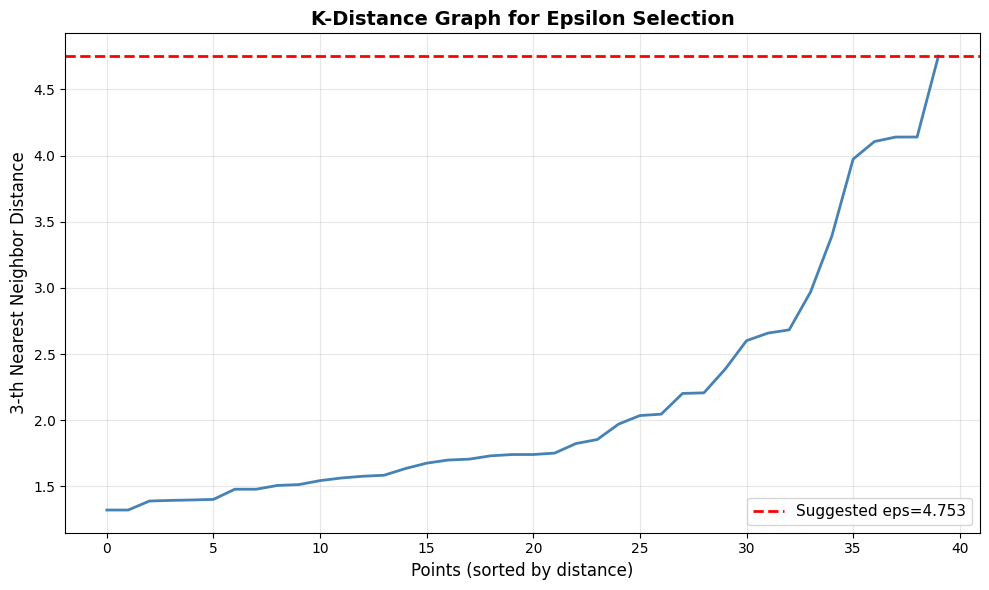


[4/6] Running DBSCAN clustering...
   Clusters found: 4
   Noise points: 7
   Clustered points: 33

[5/6] Generating t-SNE visualization...


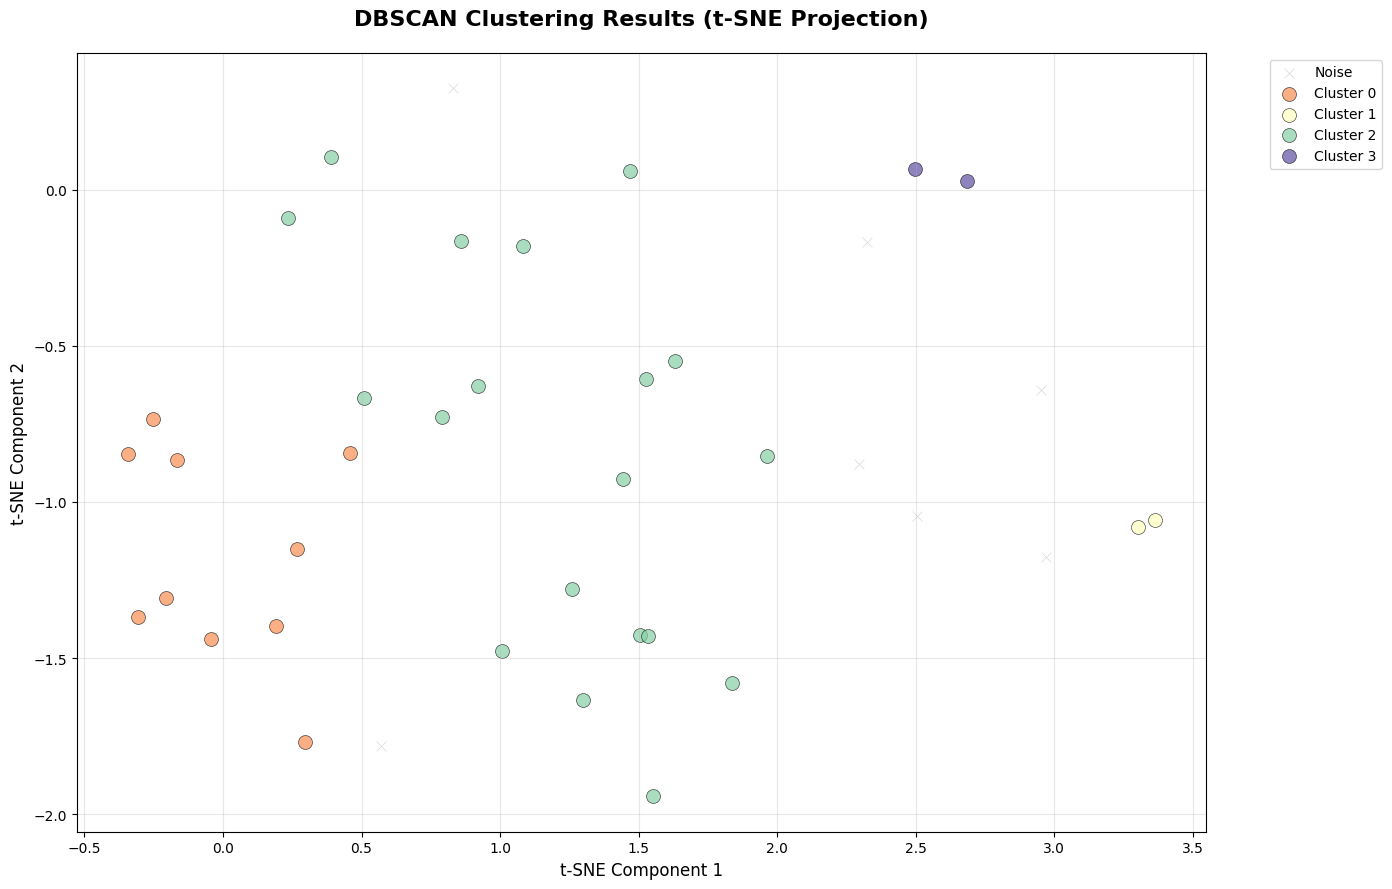


[6/6] Plotting cluster size distribution...


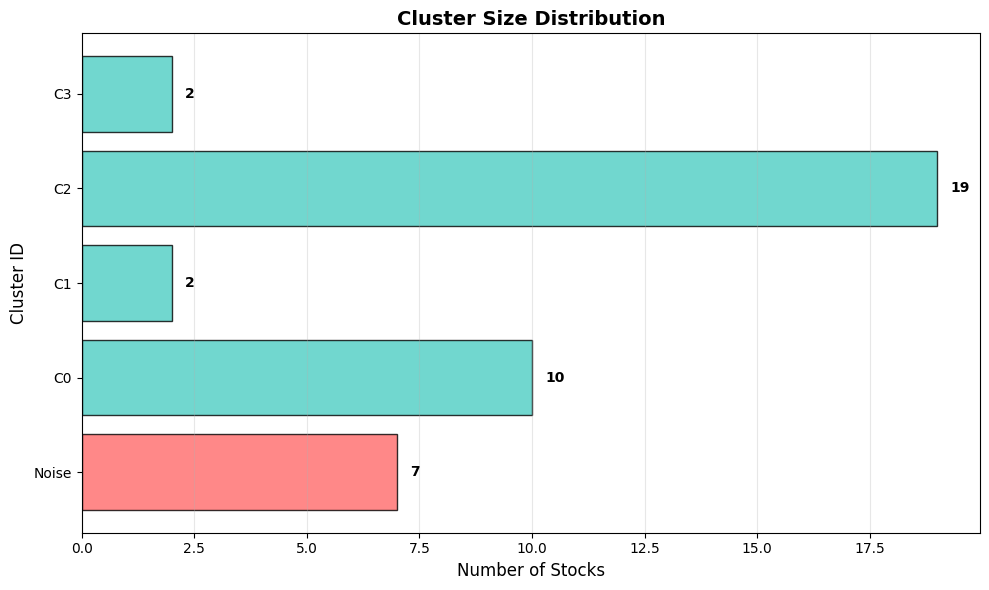


CLUSTERING SUMMARY

Cluster Assignments:

Noise (7 stocks):
  AMD, INTC, MU, SMTC, SNPS, TOELY, VICR

Cluster 0 (10 stocks):
  ADI, CDNS, GFS, NXPI, POWI, QCOM, QRVO, STM, SWKS, TXN

Cluster 1 (2 stocks):
  ALAB, CRDO

Cluster 2 (19 stocks):
  AMAT, ARM, ASML, AVGO, CAMT, CEVA, ENTG, KLAC, LRCX, LSCC, MCHP, MPWR, MRVL, MTSI, NVDA, NVMI, ON, TER, TSM

Cluster 3 (2 stocks):
  STX, WDC


Cluster Statistics:
         Count
Cluster       
 2          19
 0          10
-1           7
 1           2
 3           2


✓ Clustering complete! Variables created:
  - labels: Cluster assignments array
  - cluster_df: DataFrame with ticker-cluster mapping
  - X_pca: PCA-transformed feature matrix
  - tickers: List of ticker symbols


In [36]:
# ============================================================================
# DBSCAN CLUSTERING CELL
# Copy this entire cell into your notebook after the feature engineering step
# ============================================================================

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------------
# STEP 1: PREPARE FEATURE MATRIX FROM TIME-SERIES DATA
# ----------------------------------------------------------------------------

# Assumes you have 'ts_df' from your feature engineering step
# ts_df should have MultiIndex (Datetime, Ticker) with columns like:
# ['Price', 'Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']

print("=" * 70)
print("DBSCAN CLUSTERING ANALYSIS")
print("=" * 70)

# Define which features to use for clustering
features_to_cluster = ['Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']

# Option A: Use mean/std statistics across time (more stable)
print("\n[1/6] Aggregating features across time...")
agg_dict = {col: ['mean', 'std'] for col in features_to_cluster if col in ts_df.columns}
ticker_features = ts_df.groupby(level='Ticker').agg(agg_dict)

# Flatten column names
ticker_features.columns = ['_'.join(col).strip() for col in ticker_features.columns.values]
tickers = ticker_features.index.tolist()

print(f"   Features shape: {ticker_features.shape}")
print(f"   Tickers: {len(tickers)}")

# ----------------------------------------------------------------------------
# STEP 2: STANDARDIZE AND APPLY PCA
# ----------------------------------------------------------------------------

print("\n[2/6] Scaling and applying PCA...")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ticker_features)

# PCA with variance threshold
variance_threshold = 0.90  # Retain 90% of variance
pca = PCA(n_components=variance_threshold)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_.sum()
n_components = X_pca.shape[1]

print(f"   PCA components: {n_components}")
print(f"   Explained variance: {explained_var:.2%}")

# ----------------------------------------------------------------------------
# STEP 3: DETERMINE OPTIMAL EPSILON (AUTO-DETECT)
# ----------------------------------------------------------------------------

print("\n[3/6] Determining optimal epsilon...")

# Compute k-nearest neighbor distances
k = 3  # min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Sort k-th nearest neighbor distances
k_distances = np.sort(distances[:, k], axis=0)

# Find knee point (point of maximum curvature)
first_deriv = np.diff(k_distances)
second_deriv = np.diff(first_deriv)
knee_idx = np.argmax(second_deriv) + 2
suggested_eps = k_distances[knee_idx]

print(f"   Mean k-distance: {k_distances.mean():.4f}")
print(f"   Suggested epsilon: {suggested_eps:.4f}")

# Plot k-distance graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_distances, linewidth=2, color='steelblue')
ax.axhline(y=suggested_eps, color='red', linestyle='--', linewidth=2,
           label=f'Suggested eps={suggested_eps:.3f}')
ax.set_xlabel('Points (sorted by distance)', fontsize=12)
ax.set_ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
ax.set_title('K-Distance Graph for Epsilon Selection', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# STEP 4: RUN DBSCAN CLUSTERING
# ----------------------------------------------------------------------------

print("\n[4/6] Running DBSCAN clustering...")

# Clustering parameters
eps = 1.7  # Use auto-detected value (or override: eps = 2.5)
min_samples = 2

# Run DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(X_pca)

# Cluster statistics
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"   Clusters found: {n_clusters}")
print(f"   Noise points: {n_noise}")
print(f"   Clustered points: {len(labels) - n_noise}")

# ----------------------------------------------------------------------------
# STEP 5: VISUALIZE CLUSTERS (t-SNE)
# ----------------------------------------------------------------------------

print("\n[5/6] Generating t-SNE visualization...")

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_pca)-1))
X_tsne = tsne.fit_transform(X_pca)

# Plot
fig, ax = plt.subplots(figsize=(14, 9))

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(sorted(unique_labels), colors):
    if label == -1:
        # Noise points
        color = 'gray'
        marker = 'x'
        label_name = 'Noise'
        alpha = 0.3
        size = 50
    else:
        marker = 'o'
        label_name = f'Cluster {label}'
        alpha = 0.7
        size = 100
    
    mask = labels == label
    ax.scatter(
        X_tsne[mask, 0], 
        X_tsne[mask, 1],
        c=[color],
        label=label_name,
        marker=marker,
        s=size,
        alpha=alpha,
        edgecolors='black',
        linewidths=0.5
    )

ax.set_title('DBSCAN Clustering Results (t-SNE Projection)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('t-SNE Component 1', fontsize=12)
ax.set_ylabel('t-SNE Component 2', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# STEP 6: CLUSTER SIZE DISTRIBUTION
# ----------------------------------------------------------------------------

print("\n[6/6] Plotting cluster size distribution...")

unique, counts = np.unique(labels, return_counts=True)

# Sort by cluster ID
sort_idx = np.argsort(unique)
sorted_keys = unique[sort_idx]
sorted_counts = counts[sort_idx]
sorted_labels = ['Noise' if k == -1 else f'C{k}' for k in sorted_keys]

# Plot
fig, ax = plt.subplots(figsize=(10, max(6, len(sorted_keys) * 0.5)))
y_pos = np.arange(len(sorted_keys))

colors = ['#ff6b6b' if k == -1 else '#4ecdc4' for k in sorted_keys]
bars = ax.barh(y_pos, sorted_counts, color=colors, alpha=0.8, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_labels, fontsize=10)
ax.set_xlabel('Number of Stocks', fontsize=12)
ax.set_ylabel('Cluster ID', fontsize=12)
ax.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')

# Add count labels
for i, v in enumerate(sorted_counts):
    ax.text(v + 0.3, i, str(v), color='black', va='center', fontweight='bold')

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# RESULTS SUMMARY
# ----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("CLUSTERING SUMMARY")
print("=" * 70)

# Create results DataFrame
cluster_df = pd.DataFrame({
    'Ticker': tickers,
    'Cluster': labels
})

# Print cluster assignments
print("\nCluster Assignments:")
for cluster_id in sorted(set(labels)):
    members = cluster_df[cluster_df['Cluster'] == cluster_id]['Ticker'].tolist()
    if cluster_id == -1:
        print(f"\nNoise ({len(members)} stocks):")
    else:
        print(f"\nCluster {cluster_id} ({len(members)} stocks):")
    print("  " + ", ".join(members))

# Cluster statistics table
print("\n\nCluster Statistics:")
cluster_stats = cluster_df.groupby('Cluster').agg(
    Count=('Ticker', 'size')
).sort_values('Count', ascending=False)
print(cluster_stats)

print("\n" + "=" * 70)

# Store results for next step (pair validation)
print("\n✓ Clustering complete! Variables created:")
print("  - labels: Cluster assignments array")
print("  - cluster_df: DataFrame with ticker-cluster mapping")
print("  - X_pca: PCA-transformed feature matrix")
print("  - tickers: List of ticker symbols")